In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tqdm

import matplotlib.pyplot as plt
import imageio
from skimage.transform import resize
import pathlib

import tensorflow as tf
import tensorflow_datasets as tfds

C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


#### load data

In [2]:
dataset_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='lfw',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

13233


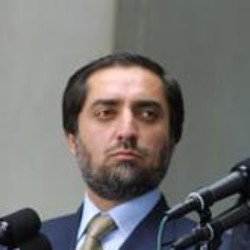

In [4]:
abdullah = list(data_dir.glob('Abdullah/*'))
PIL.Image.open(str(abdullah[0]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 11910 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=64)

Found 13233 files belonging to 5749 classes.
Using 1323 files for validation.


In [8]:
print('train shape:', tf.data.experimental.cardinality(train_ds).numpy())
print('valid shape:', tf.data.experimental.cardinality(val_ds).numpy())

train shape: 373
valid shape: 21


In [9]:
class_names = train_ds.class_names
print(class_names)

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adelina_Avila', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrien_Brody', 'Afton_Smith', 'Agbani_Darego', 'Agn

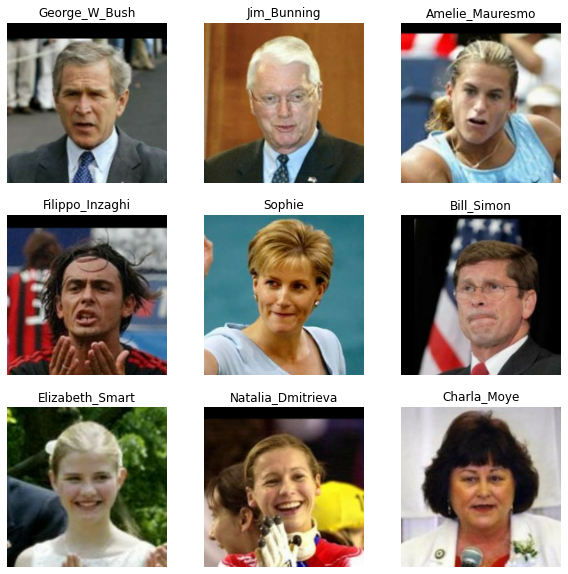

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)

(32, 180, 180, 3)
(32,)


#### model

In [12]:
EMB_SIZE = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255), # normalization layer
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [13]:
MARGIN = 7.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]
    
    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [14]:
NUM_EPOCHS = 100
train_ds = train_ds.repeat(NUM_EPOCHS)

In [15]:
LEARNING_RATE = 1e-04
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [16]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 37.82623291015625
[200] Loss: 0.1626676470041275
[400] Loss: 7.866896152496338
[600] Loss: 0.0
[800] Loss: 0.08519390225410461
[1000] Loss: 0.012769512832164764
[1200] Loss: 0.0
[1400] Loss: 0.0
[1600] Loss: 0.0
[1800] Loss: 0.4352639615535736
[2000] Loss: 0.01875266246497631
[2200] Loss: 0.022086383774876595
[2400] Loss: 0.0002684161008801311
[2600] Loss: 0.0
[2800] Loss: 0.003562767757102847
[3000] Loss: 0.2527907192707062
[3200] Loss: 0.00040039984742179513
[3400] Loss: 0.0
[3600] Loss: 0.0
[3800] Loss: 9.675227165222168
[4000] Loss: 0.0
[4200] Loss: 0.1343756914138794
[4400] Loss: 0.41837066411972046
[4600] Loss: 0.0
[4800] Loss: 0.1414870172739029
[5000] Loss: 0.0
[5200] Loss: 0.001213434268720448
[5400] Loss: 0.0
[5600] Loss: 4.611236572265625
[5800] Loss: 0.0
[6000] Loss: 0.07385334372520447
[6200] Loss: 0.0
[6400] Loss: 0.11245684325695038
[6600] Loss: 0.0
[6800] Loss: 0.017246069386601448
[7000] Loss: 0.08809418976306915
[7200] Loss: 0.0
[7400] Loss: 0.0
[7600] Loss:

#### test model

In [19]:
test_data = val_ds.take(1)
val = [(x,y) for x,y in test_data]
test_x = val[0][0].numpy()
test_y = val[0][1].numpy()

In [20]:
test_y

array([2688, 5458,  706, 4456,  976, 1047, 3903, 2174, 4551, 4929, 5494,
       3822, 3198, 2506,  385,  304, 4947,  248, 5039,  620, 5592,  580,
       3396, 2920, 5371,  388,  788, 1643, 2822, 4836,  856, 4595, 1764,
       2276, 3399, 4994,  558, 4768, 1753, 4192, 1047,  237, 5427, 1182,
       1290,  897, 1047,  751, 3861, 1798, 5354, 5425, 3617, 4939, 5581,
       1127,  876, 3737, 1598, 1512, 1047,   13, 3140, 4333])

In [21]:
[i for i, j in enumerate(test_y) if j == 1047]

[5, 40, 46, 60]

In [25]:
img_a1 = test_x[5]
img_a2 = test_x[40]
img_a3 = test_x[46]
img_b1 = test_x[2]

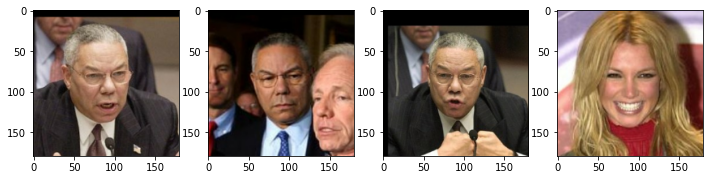

In [26]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1.astype("uint8"))
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2.astype("uint8"))
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_a3.astype("uint8"))
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_b1.astype("uint8"))
plt.show()

In [27]:
new_embs = model(np.stack((img_a1, img_a2, img_a3, img_b1), axis=0))

In [29]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]
emb4 = new_embs[3,:]

In [30]:
print('A1 <-> A2: ', diff(emb1, emb2))
print('A1 <-> A3: ', diff(emb1, emb3))
print('A2 <-> A3: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb4))
print('A2 <-> B1: ', diff(emb2, emb4))
print('A3 <-> B1: ', diff(emb3, emb4))

A1 <-> A2:  8.297343037940387
A1 <-> A3:  5.635329532008414
A2 <-> A3:  8.323916289671644
A1 <-> B1:  10.461429780939287
A2 <-> B1:  11.64930334013785
A3 <-> B1:  11.517444813593842


### test on own images

In [31]:
def load_and_prepare_image(fpath):
    img = imageio.imread(fpath)
#     img = img.astype(np.float32) / 255.
    img = resize(img, (180, 180))
    return img

img_a1 = load_and_prepare_image('0.jpg')
img_a2 = load_and_prepare_image('1.jpg')
img_a3 = load_and_prepare_image('2.jpg')
img_b1 = load_and_prepare_image('3.jpg')

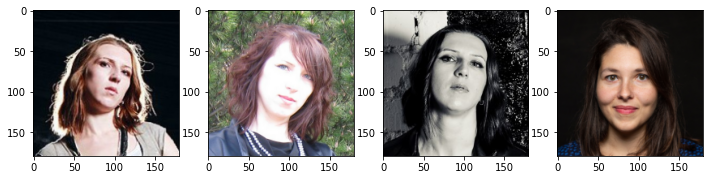

In [32]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_a3)
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_b1)
plt.show()

In [33]:
new_embs = model(np.stack((img_a1, img_a2, img_a3, img_b1), axis=0))

In [34]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]
emb4 = new_embs[3,:]

In [35]:
print('A1 <-> A2: ', diff(emb1, emb2))
print('A1 <-> A3: ', diff(emb1, emb3))
print('A2 <-> A3: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb4))
print('A2 <-> B1: ', diff(emb2, emb4))
print('A3 <-> B1: ', diff(emb3, emb4))

A1 <-> A2:  0.45564807352006015
A1 <-> A3:  0.3680581868975324
A2 <-> A3:  0.4927871018797133
A1 <-> B1:  0.35230564410414666
A2 <-> B1:  0.5429507465259406
A3 <-> B1:  0.4311449302995061
